<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Region                                   267 non-null    object 
 1   Date                                     267 non-null    object 
 2   Frequency                                267 non-null    object 
 3   Estimated Unemployment Rate (%)          267 non-null    float64
 4   Estimated Employed                       267 non-null    int64  
 5   Estimated Labour Participation Rate (%)  267 non-null    float64
 6   Region.1                                 267 non-null    object 
 7   Longitude                                267 non-null    float64
 8   Latitude                                 267 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 18.9+ KB
None
       Estimated Unemployment Rate (%)  Estimated Employed

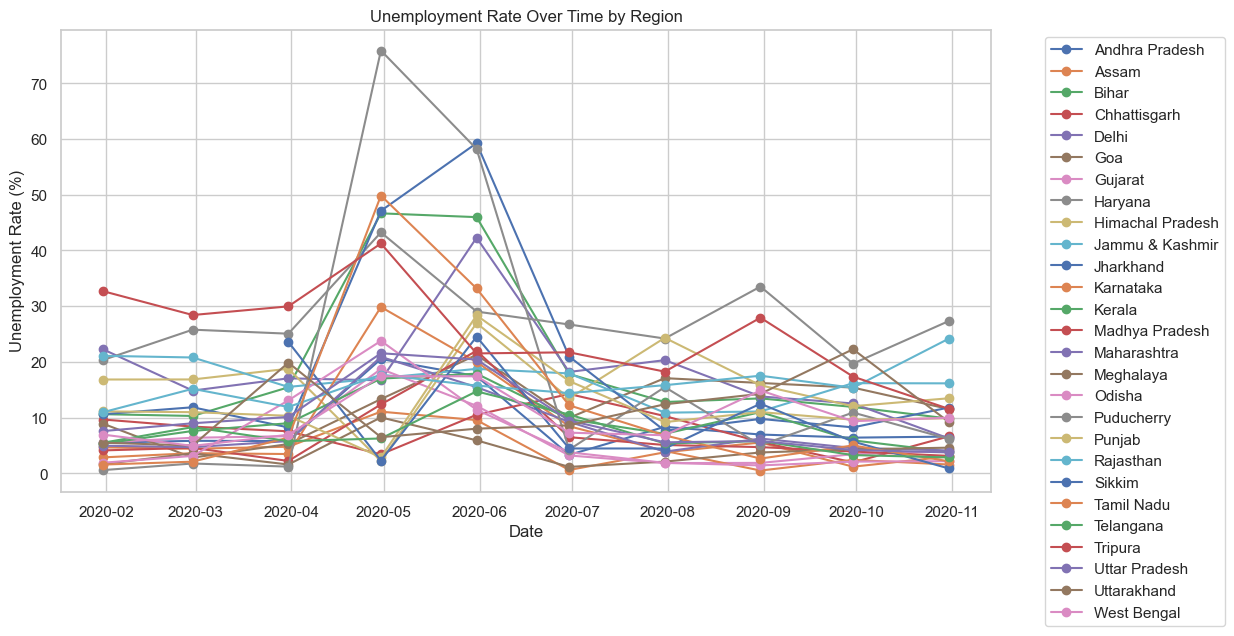

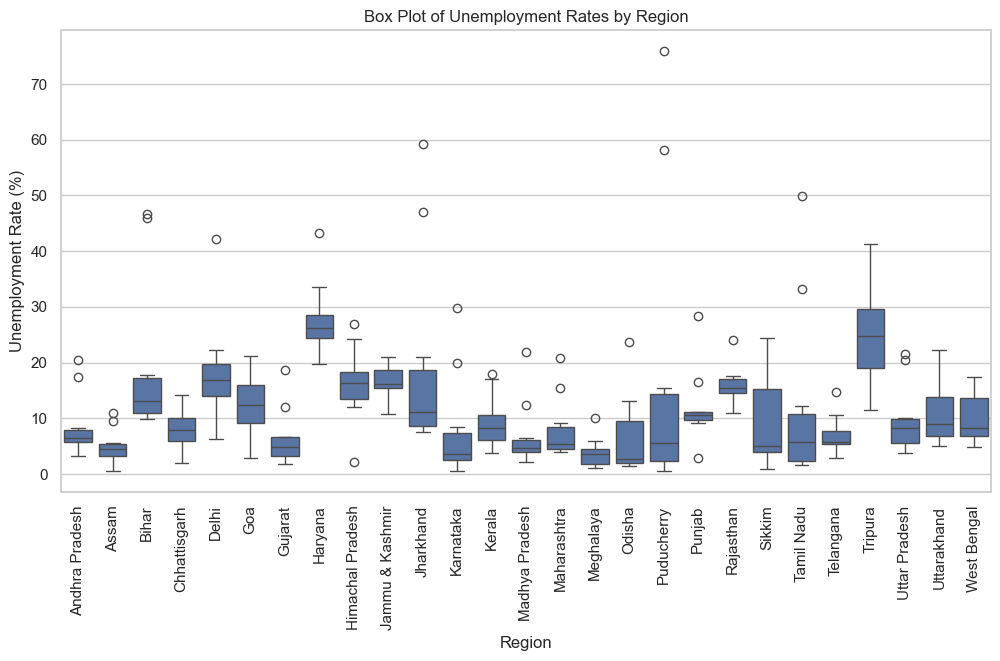

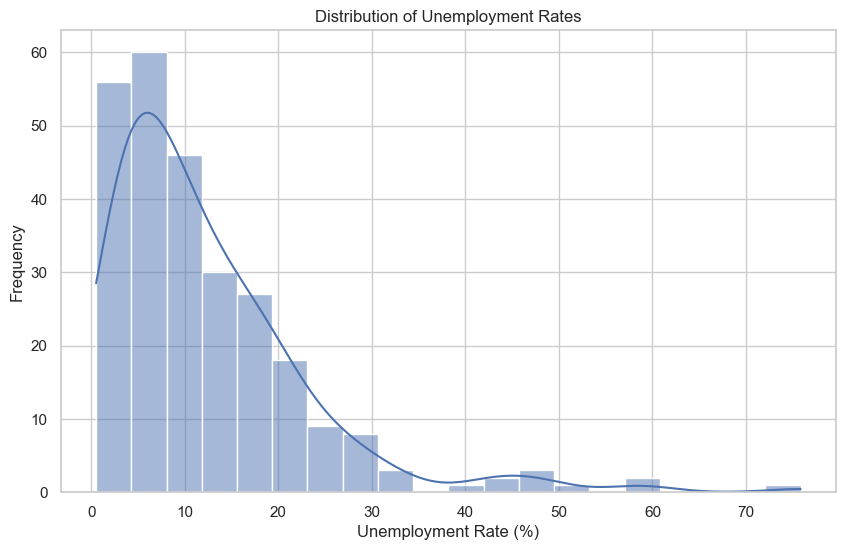

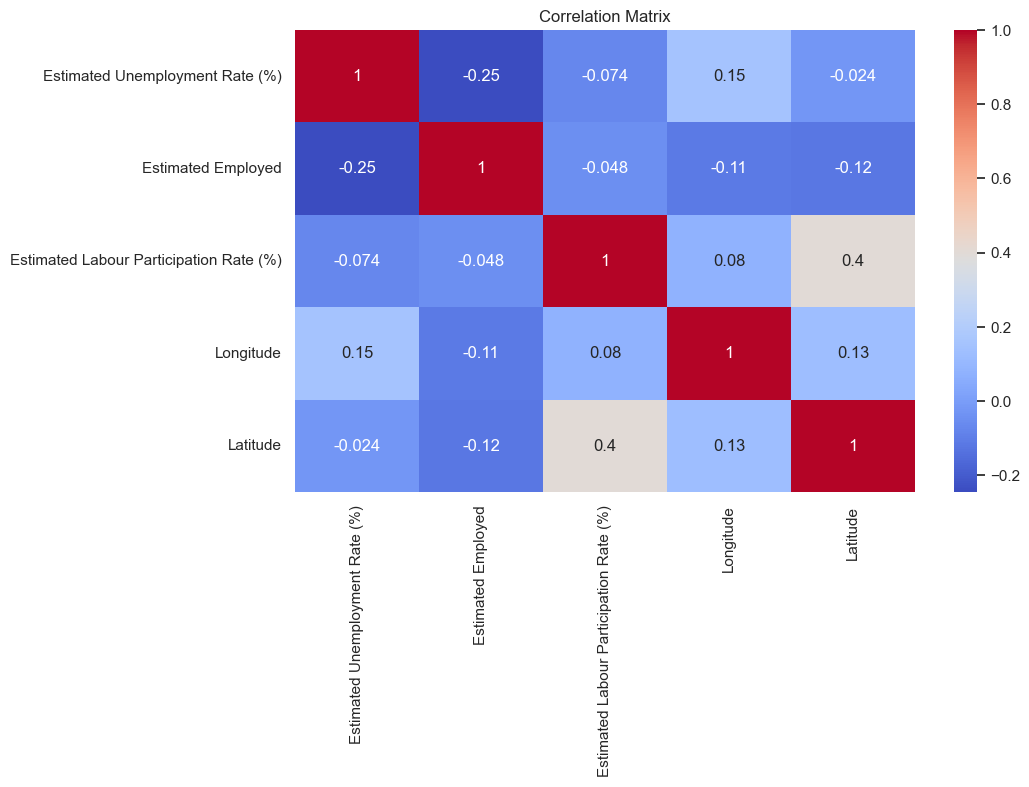

Training size: 8
Testing size: 2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=60.911, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.927, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59.045, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=61.029, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56.798, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.941, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.273 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    8
Model:                        SARIMAX   Log Likelihood       

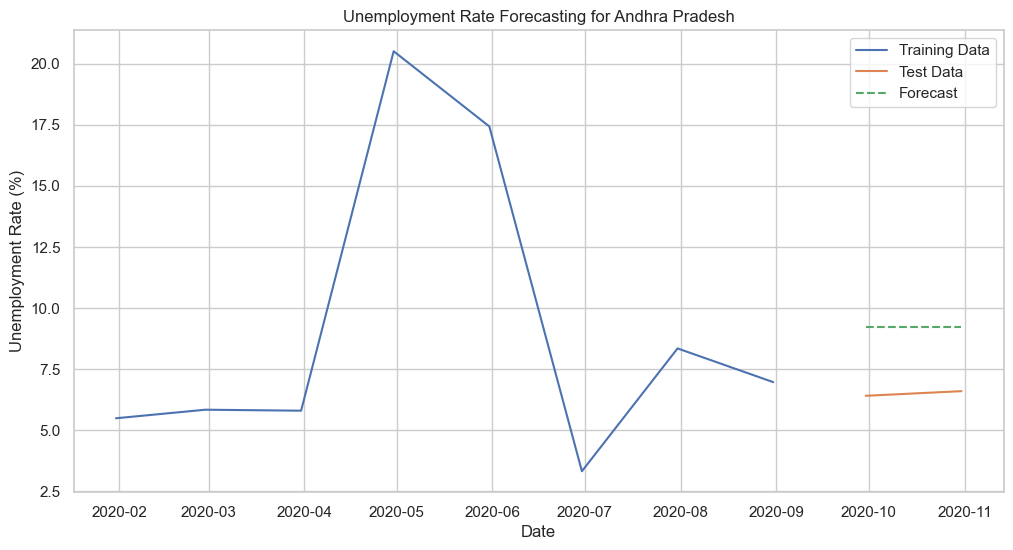

Mean Squared Error: 7.359872317437542


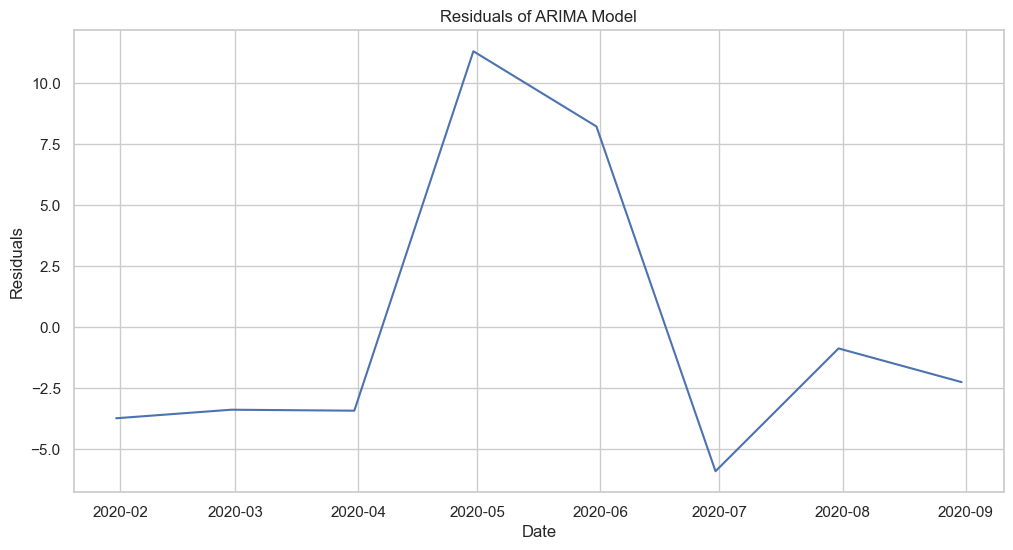

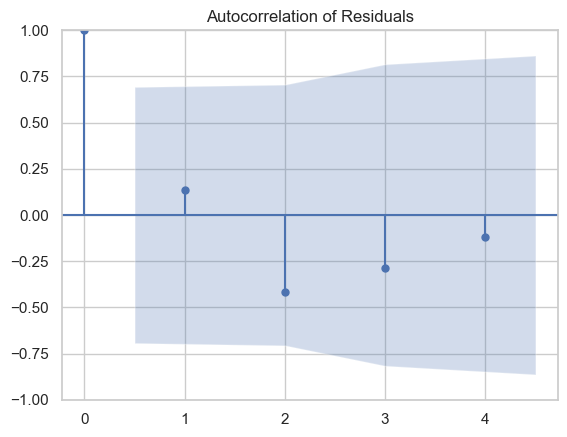

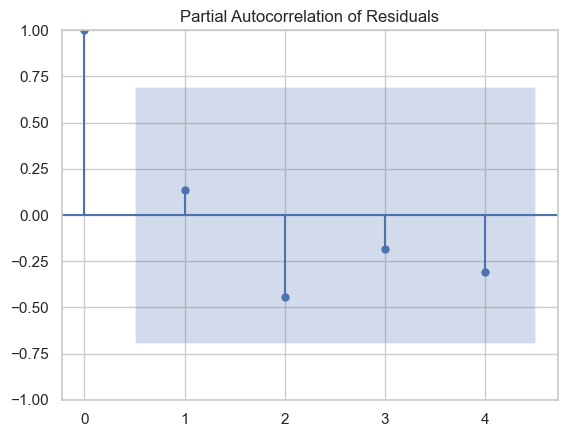

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plotting styles
sns.set(style="whitegrid")

# Ensure plots are displayed in the notebook
%matplotlib inline

# Load data
file_path = '../data/Unemployment_Rate_upto_11_2020.xlsx'
unemployment_data = pd.read_excel(file_path)

# Display basic information about the dataset
print(unemployment_data.info())
print(unemployment_data.describe())

# Convert Date column to datetime
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'], format='%d-%m-%Y')

# Drop redundant column
unemployment_data = unemployment_data.drop(columns=['Region.1'])

# Check for missing values
print(unemployment_data.isnull().sum())

# Display first few rows of the cleaned dataframe
print(unemployment_data.head())

# Line plot of unemployment rate over time
plt.figure(figsize=(12, 6))
for region in unemployment_data['Region'].unique():
    region_data = unemployment_data[unemployment_data['Region'] == region]
    plt.plot(region_data['Date'], region_data['Estimated Unemployment Rate (%)'], marker='o', label=region)

plt.title('Unemployment Rate Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Box plot of unemployment rates by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Estimated Unemployment Rate (%)', data=unemployment_data)
plt.xticks(rotation=90)
plt.title('Box Plot of Unemployment Rates by Region')
plt.xlabel('Region')
plt.ylabel('Unemployment Rate (%)')
plt.show()

# Histogram of unemployment rates
plt.figure(figsize=(10, 6))
sns.histplot(unemployment_data['Estimated Unemployment Rate (%)'], bins=20, kde=True)
plt.title('Distribution of Unemployment Rates')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix
numeric_cols = unemployment_data.select_dtypes(include=[np.number]).columns
correlation_matrix = unemployment_data[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Select a region for forecasting
region = 'Andhra Pradesh'
region_data = unemployment_data[unemployment_data['Region'] == region].copy()

# Set Date as the index
region_data.set_index('Date', inplace=True)

# Ensure the data has a monthly frequency
region_data = region_data.asfreq('M')

# Train-test split
train_size = int(len(region_data) * 0.8)
train, test = region_data.iloc[:train_size], region_data.iloc[train_size:]

print(f'Training size: {len(train)}')
print(f'Testing size: {len(test)}')

# Automatic ARIMA model selection
auto_model = auto_arima(train['Estimated Unemployment Rate (%)'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

# Fit ARIMA model
model = ARIMA(train['Estimated Unemployment Rate (%)'], order=auto_model.order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
test = test.copy()  # Avoid SettingWithCopyWarning
test['Forecast'] = forecast

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Estimated Unemployment Rate (%)'], label='Training Data')
plt.plot(test.index, test['Estimated Unemployment Rate (%)'], label='Test Data')
plt.plot(test.index, test['Forecast'], label='Forecast', linestyle='--')
plt.title(f'Unemployment Rate Forecasting for {region}')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test['Estimated Unemployment Rate (%)'], test['Forecast'])
print(f'Mean Squared Error: {mse}')

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF plots of residuals
plot_acf(residuals)
plt.title('Autocorrelation of Residuals')
plt.show()

plot_pacf(residuals)
plt.title('Partial Autocorrelation of Residuals')
plt.show()
